In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader , Dataset
from torchvision import transforms
import torchvision
from tqdm import tqdm

In [2]:
BATCH_SIZE = 2
IMAGE_SIZE_W = 1656 # 828
IMAGE_SIZE_H = 1176
EPOCHS = 20

images_path = "splitted_images"
labels_path = "splitted_labels"

In [3]:
trainFolders = [
     'ARMS',
     'AisazuNihaIrarenai',
     'AkkeraKanjinchou',
     'Akuhamu',
     'AosugiruHaru',
     'AppareKappore',
     'Arisa',
     'BEMADER_P',
     'BakuretsuKungFuGirl',
     'Belmondo',
     'BokuHaSitatakaKun',
     'BurariTessenTorimonocho',
     'ByebyeC-BOY',
     'Count3DeKimeteAgeru',
     'DollGun',
     'Donburakokko',
     'DualJustice',
     'EienNoWith',
     'EvaLady',
     'EverydayOsakanaChan',
     'GOOD_KISS_Ver2',
     'GakuenNoise',
     'GarakutayaManta',
     'GinNoChimera',
     'Hamlet',
     'HanzaiKousyouninMinegishiEitarou',
     'HaruichibanNoFukukoro',
     'HarukaRefrain',
     'HealingPlanet',
     "UchiNoNyan'sDiary",
     'UchuKigekiM774',
     'UltraEleven',
     'UnbalanceTokyo',
     'WarewareHaOniDearu',
     'YamatoNoHane',
     'YasasiiAkuma',
     'YouchienBoueigumi',
     'YoumaKourin',
     'YukiNoFuruMachi',
     'YumeNoKayoiji',

]

testFolders = [     
     'YumeiroCooking',
     'TotteokiNoABC',
     'ToutaMairimasu',
     'TouyouKidan',
     'TsubasaNoKioku'
]

In [4]:
class Manga109Dataset(Dataset):
    def __init__(self, images_path, labels_path, books, transform_colored=None, transform_gray=None, colored=False):
        
        if colored:
            assert transform_colored is not None, "Need colored_transform"
        else:
            assert transform_gray is not None, "Need gray_transform"
            
        self.images_path = images_path
        self.labels_path = labels_path
        
        self.books = books
        
        self.colored = colored
        self.transform_gray = transform_gray
        self.transform_colored = transform_colored
        
        self.to_tensor = transforms.ToTensor()
        
        self.len = 0
        
        self.index = {}
        
        for book in self.books:
            img_files = os.listdir(os.path.join(images_path, book))
            self.len += len(img_files)
            
            self.index[book] = img_files 
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        
        for book in self.books:
            if idx >= len(self.index[book]):
                idx -= len(self.index[book])
            else:
                try:
                    file_name = self.index[book][idx]
                    train_file_path = os.path.join(self.images_path, book, file_name)
                    label_file_path = os.path.join(self.labels_path, book, file_name)
                    break
                except:
                    raise IndexError("list index out of range")
            
        
        
        train_img = cv2.imread(train_file_path, cv2.IMREAD_COLOR)
        label_img = cv2.imread(label_file_path, cv2.IMREAD_COLOR)
        train_img = np.pad(train_img, pad_width=((6, 0), (1, 0), (0, 0)), constant_values=0)
        label_img = np.pad(label_img, pad_width=((6, 0), (1, 0), (0, 0)), constant_values=255)
        
        label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2GRAY)
        label_img = 255 - label_img
        _, label_img = cv2.threshold(label_img, 200, 255, cv2.THRESH_BINARY)
        
        train_img = train_img / 255
        label_img = label_img / 255
        
        if self.colored:
            train_img = self.transform_colored(train_img)
        else:
            train_img = self.transform(train_img)
            
            
        label_img = self.to_tensor(label_img)
        
        return train_img.float(), label_img.float()

In [5]:

transform_colored = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = Manga109Dataset(images_path, labels_path, trainFolders, colored=True, transform_colored=transform_colored)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


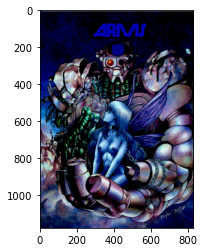

In [6]:
x, y = dataset[0]
x = np.transpose(x.numpy(), axes=(1, 2, 0))
y = np.transpose(y.numpy(), axes=(1, 2, 0))
plt.imshow(x, vmin=0, vmax=1)

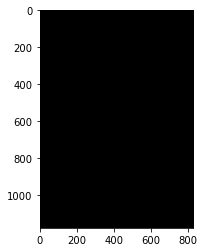

In [7]:
plt.imshow(y, cmap='gray')

In [8]:
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

In [9]:
import torch.nn as nn
import torch.nn.functional as F


### If you run on GPU you must load it to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class JapaneseTextDetector(nn.Module):
    def __convBlock(self, ch_in, ch_out, padding, kernel_size):
        conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, padding=padding, kernel_size=kernel_size),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            
            nn.Conv2d(ch_out, ch_out, kernel_size=(1, 1)),
            nn.BatchNorm2d(ch_out),
            nn.ReLU()
        )
        
        return conv
    
    def __init__(self, img_h, img_w):
        super(JapaneseTextDetector, self).__init__()
        
        self.img_h = img_h
        self.img_w = img_w
        
        self.conv_block_1 = self.__convBlock(1, 16, padding=(1, 1), kernel_size=(3, 3)) 
        self.max_pool_1 = nn.MaxPool2d((2, 2)) # 1170x826 -> 585x413
        
        self.conv_block_2 = self.__convBlock(16, 32, padding=(1, 1), kernel_size=(3, 3)) 
        self.max_pool_2 = nn.MaxPool2d((2, 2)) # 585x413 -> 292x206
        
        self.conv_block_3 = self.__convBlock(32, 64, padding=(1, 1), kernel_size=(3, 3)) 
        self.max_pool_3 = nn.MaxPool2d((2, 2)) # 292x206 -> 146x103
        
        self.conv_block_4 = self.__convBlock(64, 128, padding=(1, 1), kernel_size=(3, 3)) 
        self.max_pool_4 = nn.MaxPool2d((2, 2)) # 146x103 -> 73x51
        
        self.deconv_1 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_filter_1 = nn.Conv2d(128, 64, kernel_size=(1, 1))
        self.conv_block_5 = self.__convBlock(64, 64, padding=(1, 1), kernel_size=(3, 3)) 
        
        self.deconv_2 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_filter_2 = nn.Conv2d(64, 32, kernel_size=(1, 1))
        self.conv_block_6 = self.__convBlock(32, 32, padding=(1, 1), kernel_size=(3, 3)) 
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 0), output_padding=(1, 0))
        
        self.conv_block_7 = nn.Conv2d(32, 1, padding=(1, 1), kernel_size=(3, 3))
        
    def forward(self, x):
        c1 = self.conv_block_1(x)
        x = self.max_pool_1(c1)
        
        c2 = self.conv_block_2(x)
        x = self.max_pool_2(c2)
        
        c3 = self.conv_block_3(x)
        x = self.max_pool_3(c3)
        
        x = self.conv_block_4(x)
        
        x = self.deconv_1(x)
        
        x = torch.cat((c3, x), 1)
        x = self.conv_filter_1(x)
        
        x = self.conv_block_5(x)
        x = self.deconv_2(x)
        
        x = torch.cat((c2, x), 1)
        x = self.conv_filter_2(x)
        
        x = self.conv_block_6(x)
        x = self.deconv_3(x)
        
        x = torch.cat((c1, x), 1)
        x = self.conv_block_7(x)

        return x

In [11]:
class Resnet34(nn.Module):
    def __init__(self):
        super(Resnet34, self).__init__()
        
        resnet34 = torchvision.models.resnet34(pretrained=True)
        
        self.conv1 = resnet34.conv1
        self.maxpool = resnet34.maxpool
        self.layer1 = resnet34.layer1
        self.layer2 = resnet34.layer2
        self.layer3 = resnet34.layer3
        self.layer4 = resnet34.layer4
        
        
    def forward(self, x):
        x = self.conv1(x)
        e1 = self.maxpool(x)
        e1 = self.layer1(e1)
        e2 = self.layer2(e1)
        e3 = self.layer3(e2)
        e4 = self.layer4(e3)
        
        return x, e1, e2, e3, e4

In [12]:
class PretrainedTextDetector(nn.Module):
    def __doubleConv(self, ch_in, ch_out, padding, kernel_size):
        conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, padding=padding, kernel_size=kernel_size),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            
            nn.Conv2d(ch_out, ch_out, padding=padding, kernel_size=kernel_size),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
        )
        
        return conv
    
    def __init__(self, img_h, img_w, finetune=False):
        super(PretrainedTextDetector, self).__init__()

        self.img_h = img_h
        self.img_w = img_w
        self.finetune = finetune
        self.resnet = Resnet34()
        
        
        
        self.conv_1 = self.__doubleConv(512, 512, (1, 1), (3, 3))
        
        self.deconv_1 = nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_2 = self.__doubleConv(512, 256, (1, 1), (3, 3))
        
        self.deconv_2 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(0, 1))
        
        self.conv_3 = self.__doubleConv(256, 128, (1, 1), (3, 3))
        
        self.deconv_3 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
        
        self.conv_4 = self.__doubleConv(128, 64, (1, 1), (3, 3))
        
        self.deconv_4 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_5 = self.__doubleConv(96, 64, (1, 1), (3, 3))
        
        self.deconv_5 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        
        self.conv_6 = self.__doubleConv(32, 16, (1, 1), (3, 3))
        self.out_conv = nn.Conv2d(16, 1, padding=(1, 1), kernel_size=(3, 3))
        
        
    def forward(self, x):
        
        if self.finetune:
            e0, e1, e2, e3, e4 = self.resnet(x)
        else:
            with torch.no_grad():
                e0, e1, e2, e3, e4 = self.resnet(x)
            
        x = self.conv_1(e4)
        
        x = self.deconv_1(x)
        
        x = torch.cat((x, e3), 1)
        
        x = self.conv_2(x)
        
        x = self.deconv_2(x)
        
        x = torch.cat((x, e2), 1)
        
        x = self.conv_3(x)
        
        x = self.deconv_3(x)
    
        x = torch.cat((x, e1), 1)
        
        x = self.conv_4(x)
        
        x = self.deconv_4(x)
        
        x = torch.cat((x, e0), 1)
        
        x = self.conv_5(x)
        
        x = self.deconv_5(x)

        x = self.conv_6(x)
        
        x = self.out_conv(x)
        return x

In [13]:
model = PretrainedTextDetector(IMAGE_SIZE_W, IMAGE_SIZE_H, finetune=False).to(device)

In [14]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [15]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [16]:
loss_fn_1 = nn.BCEWithLogitsLoss()
loss_fn_2 = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=1, threshold=1e-2)

In [17]:
def train(model,train_loader,optimizer,device):
    
    epoch_accuracy = 0
    running_loss = 0
    running_loss_1 = 0
    running_loss_2 = 0
    total = 0
    correct = 0

    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        images, y = data

        images, y = images.to(device), y.to(device)

        
        outputs = model(images)
        
        #loss_1 = loss_fn_1(outputs, y)
        loss_2 = loss_fn_2(outputs, y)
        
        loss = loss_2#loss_1 + loss_2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #running_loss_1 += loss_1.item()* images.size(0)
        running_loss_2 += loss_2.item()* images.size(0)
        
        running_loss += loss.item()* images.size(0)
        total += images.size(0)
    
    total_loss = running_loss / len(train_loader.dataset)
    #total_loss_1 = running_loss_1 / len(train_loader.dataset)
    total_loss_2 = running_loss_2 / len(train_loader.dataset)
    scheduler.step(total_loss) 
    
    print(f"Loss: {total_loss}")#\nLoss1: {total_loss_1}\nLoss2: {total_loss_2}")

In [18]:
for epoch in range(10):
    train(model, dataloader, optimizer, device)

400it [06:02,  1.10it/s]


Loss: 0.4700060375034809


400it [06:02,  1.10it/s]


Loss: 0.2905774019658566


400it [06:03,  1.10it/s]


Loss: 0.25221829637885096


400it [06:01,  1.11it/s]


Loss: 0.24395098596811293


400it [06:00,  1.11it/s]


Loss: 0.22026395604014395


400it [06:02,  1.10it/s]


Loss: 0.22054289773106575


400it [05:59,  1.11it/s]


Loss: 0.2140672995150089


400it [06:02,  1.10it/s]


Loss: 0.2465182761847973


400it [05:59,  1.11it/s]


Loss: 0.22279906675219535


400it [06:00,  1.11it/s]

Loss: 0.20120316848158837


In [19]:
x, y = next(iter(dataloader))

In [20]:
y[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [21]:
model.cpu()
out = torch.sigmoid(model(x))

In [22]:
out.shape

torch.Size([2, 1, 1176, 828])

In [23]:
out = out.cpu().detach().numpy()

In [24]:
out = out[1][0]

In [25]:
np.unique(out)

array([3.6697009e-22, 5.8979063e-22, 7.3817045e-22, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

In [54]:
copy_out = out

In [55]:
sorted_out = np.sort(copy_out.reshape(-1))
_, copy_out = cv2.threshold(copy_out, 0.1, 1, cv2.THRESH_BINARY)
#out = cv2.dilate(out, np.ones((3, 3), dtype=np.uint8))

In [56]:
(copy_out == 1).sum()

21323

In [57]:
np.unique(copy_out)

array([0., 1.], dtype=float32)

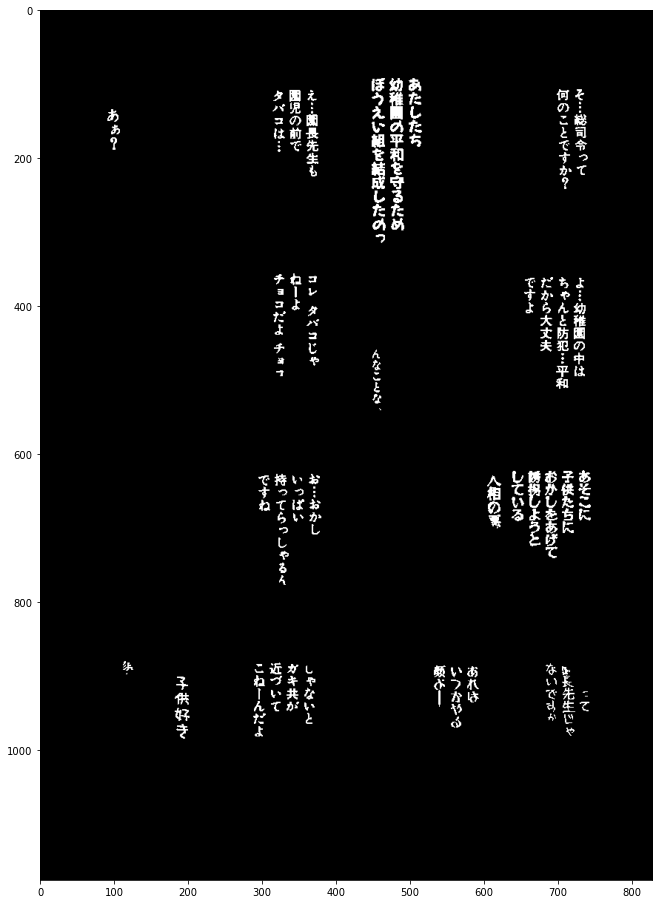

In [58]:
plt.figure(figsize=(16, 16))
plt.imshow(copy_out, cmap='gray')

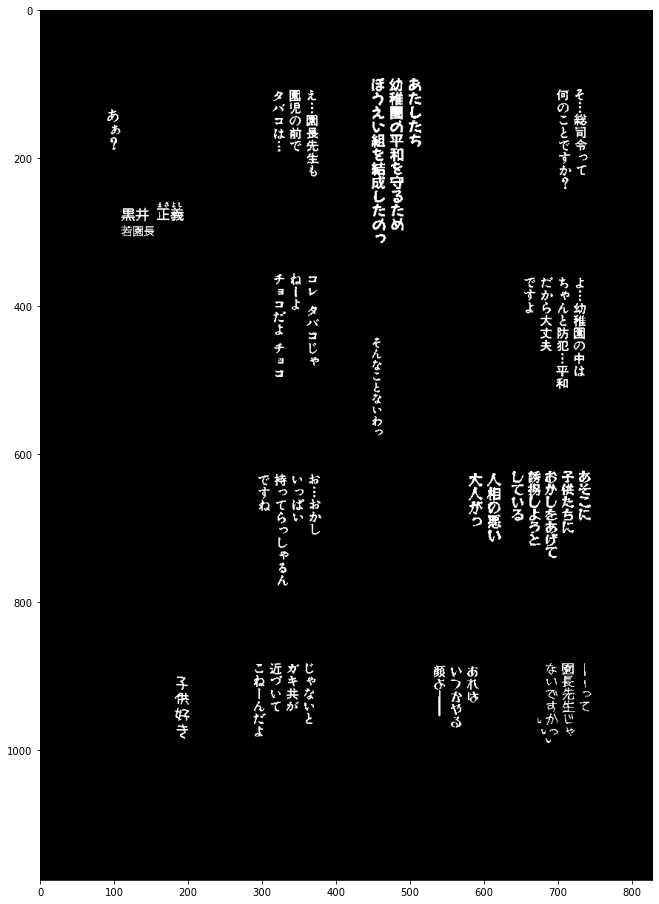

In [59]:
plt.figure(figsize=(16, 16))
plt.imshow(y[1][0], cmap='gray')

In [113]:
x_gray = cv2.cvtColor(np.transpose(x[1].numpy(), axes=(1, 2, 0)), cv2.COLOR_RGB2GRAY)

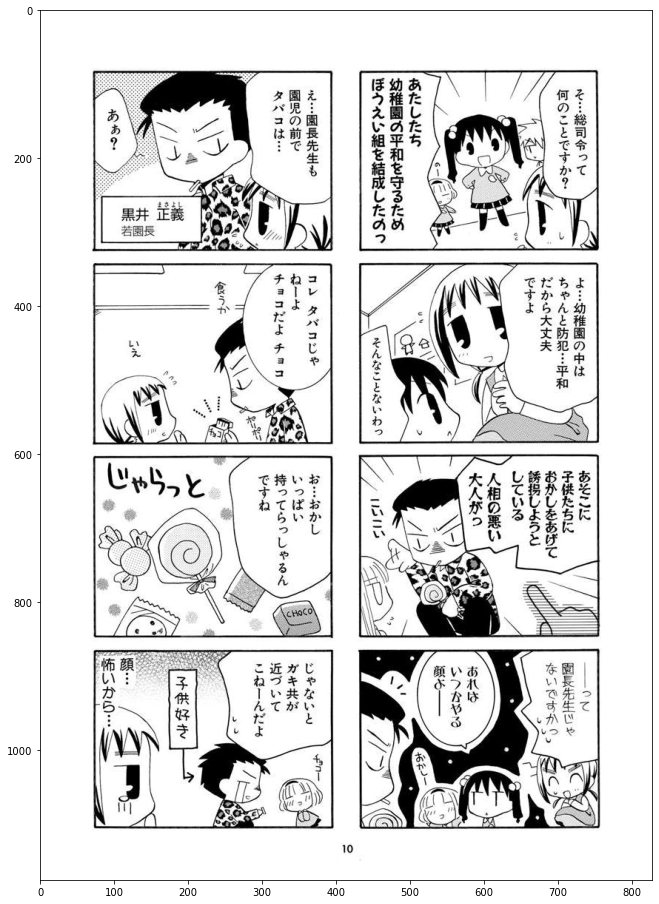

In [114]:
plt.figure(figsize=(16, 16))
plt.imshow(x_gray, cmap='gray')

In [81]:
dataset_test = Manga109Dataset(images_path, labels_path, testFolders, colored=True, transform_colored=transform_colored)
dataloader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle=True)

In [105]:
x_test, y_test = next(iter(dataloader_test))

In [106]:
out = torch.sigmoid(model(x_test)).detach().numpy()

In [107]:
sorted_out = np.sort(out.reshape(-1))
_, copy_out = cv2.threshold(out[0][0], 0.5, 1, cv2.THRESH_BINARY)

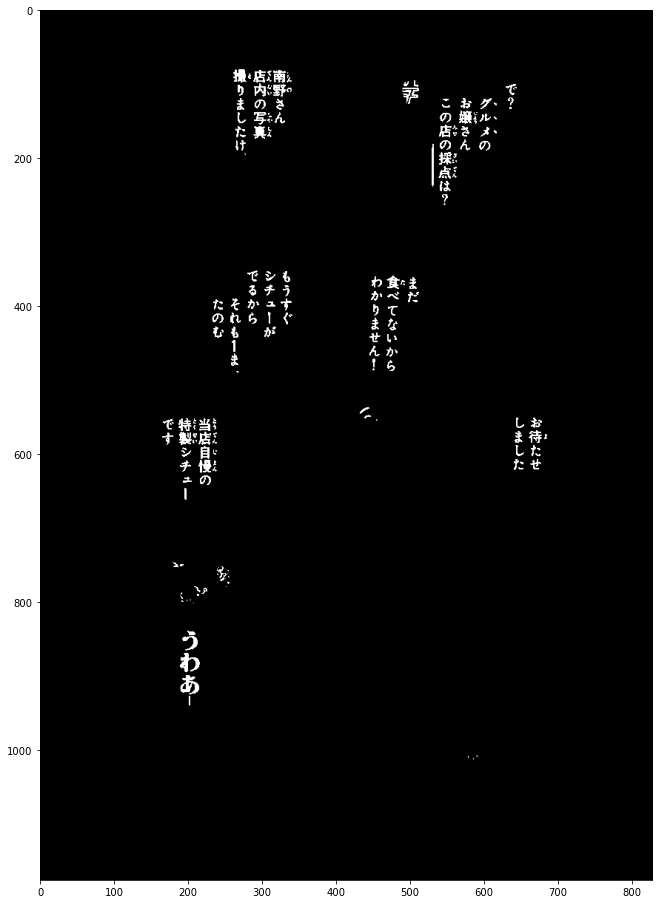

In [108]:
plt.figure(figsize=(16, 16))
plt.imshow(copy_out, cmap='gray')

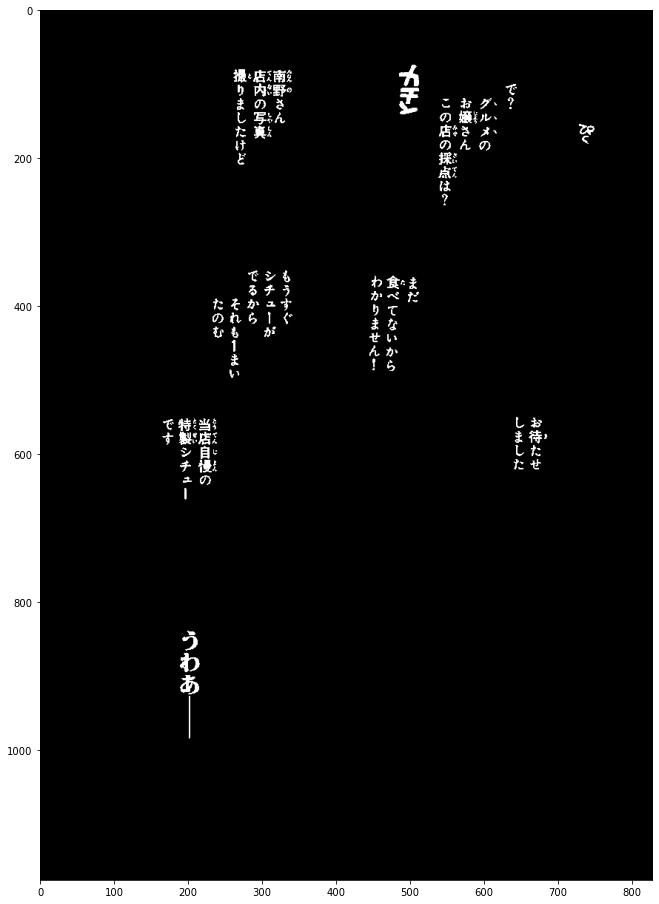

In [109]:
plt.figure(figsize=(16, 16))
plt.imshow(y_test[0][0], cmap='gray')

In [112]:
torch.save(model.state_dict(), "model.pth")